In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib as plt 
import matplotlib.pyplot as plt 
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [4]:
data = pd.read_csv("../../Data/german_credit_data.csv", index_col=0)

In [5]:
data.head(10) # Veri kümesi tablosunun ilk 10 öznitelik bilgisini verir.

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   
5   35    male    1    free             NaN              NaN           9055   
6   53    male    2     own      quite rich              NaN           2835   
7   35    male    3    rent          little         moderate           6948   
8   61    male    1     own            rich              NaN           3059   
9   28    male    3     own          little         moderate           5234   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  
5        36            education  good  
6        24  furniture/equipment  good  
7        36                  car  good  
8        12             radio/TV  good  
9        30                  car   bad

In [6]:
data.tail() # Veri kümesi tablosunun son 5 bilgisini verir.

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
995   31  female    1     own          little              NaN           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little              NaN            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration              Purpose  Risk  
995        12  furniture/equipment  good  
996        30                  car  good  
997        12             radio/TV  good  
998        45             radio/TV   bad  
999        45                  car  good

In [7]:
data.describe() # Veri kümesine ait string olmayan nümerik değeleri gösterir.

Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.000000     2.000000    3972.250000    24.000000
max      75.000000     3.000000   18424.000000    72.000000

In [8]:
data.info() # Veri kümesi ile ilgili bellek kullanımı ve veri istatistikleri

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [9]:
data.corr() # Veri kümesinde bulunan öznitelikler arasında ki ilişkiyi değerlendirir. Duration ve Credit amount arasında 62% ilişki var

Age       Job  Credit amount  Duration
Age            1.000000  0.015673       0.032716 -0.036136
Job            0.015673  1.000000       0.285385  0.210910
Credit amount  0.032716  0.285385       1.000000  0.624984
Duration      -0.036136  0.210910       0.624984  1.000000

In [10]:
data.shape # Veri kümesinin kaç satır ve sütundan oluştuğu bilgisini verir. Shape bir özelliktir ve metod olmadığı için parantez kullanılmamıştır.

(1000, 10)

In [11]:
data.columns # Veri kümesine ait sütunlarımızı gösterir.

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [12]:
print(data.nunique()) # Benzersiz türleri bulabiliriz.


Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [13]:
data.sample(5) # Veri kümesi içerisinde eksik veri olup olmadığını ilk 5 satır özetine bakarak tespit edebiliriz.


Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
119   36    male    3     own      quite rich         moderate           2366   
471   23  female    2     own          little           little            448   
548   24  female    1     own          little           little            626   
872   26    male    2     own        moderate           little           1382   
619   49    male    1     own          little              NaN            640   

     Duration    Purpose  Risk  
119        12        car  good  
471         6  education   bad  
548        12   radio/TV   bad  
872        24   business  good  
619        12        car  good

In [14]:
pd.concat([data.isnull().sum(), 100 * data.isnull().sum()/len(data)], 
              axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})  
# Veri kümesinde ki eksik veri sayılarını ve oranlarını gösterir.

Missing Records  Percentage (%)
Age                             0             0.0
Sex                             0             0.0
Job                             0             0.0
Housing                         0             0.0
Saving accounts               183            18.3
Checking account              394            39.4
Credit amount                   0             0.0
Duration                        0             0.0
Purpose                         0             0.0
Risk                            0             0.0

In [15]:
data["Saving accounts"].value_counts(dropna = False)
# Saving accounts değişkeni için her farklı değerden kaç tane olduğunu hesaplar.
# dropna = False; Eğer NaN değer var ise göster anlamına gelir.

little        603
NaN           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [16]:
data["Checking account"].value_counts(dropna = False) 

NaN         394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [17]:

for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True) 
# Kategorik değişkenlerimizi mode yöntemiyle doldurabiliriz.

In [18]:
data.head(5)

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own          little           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little           little           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

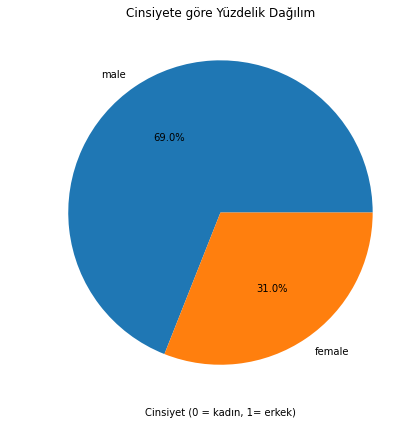

In [19]:
# 2- VERİ GÖRSELLEŞTİRME 

fig = plt.figure(figsize=(7,7))   # Veri kümesinde ki cinsiyet dağılımı
data['Sex'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.xlabel("Cinsiyet (0 = kadın, 1= erkek)")
plt.ylabel(" ", fontsize = 20)
plt.title("Cinsiyete göre Yüzdelik Dağılım")
print("")   

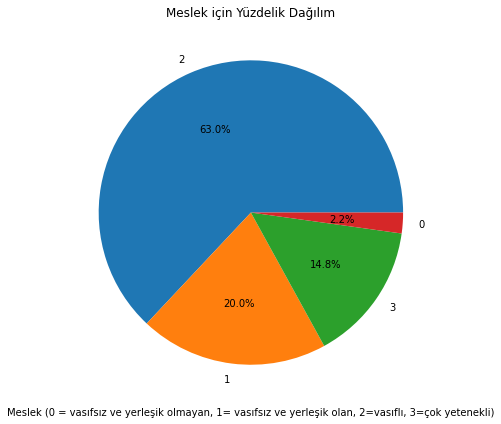

In [20]:
fig = plt.figure(figsize=(7,7))   # Veri kümesinde ki meslek dağılımı
data['Job'].value_counts().plot(kind = 'pie', autopct='%.1f%%')
plt.xlabel("Meslek (0 = vasıfsız ve yerleşik olmayan, 1= vasıfsız ve yerleşik olan, 2=vasıflı, 3=çok yetenekli)")
plt.ylabel(" ", fontsize = 20)
plt.title("Meslek için Yüzdelik Dağılım")
print("") 

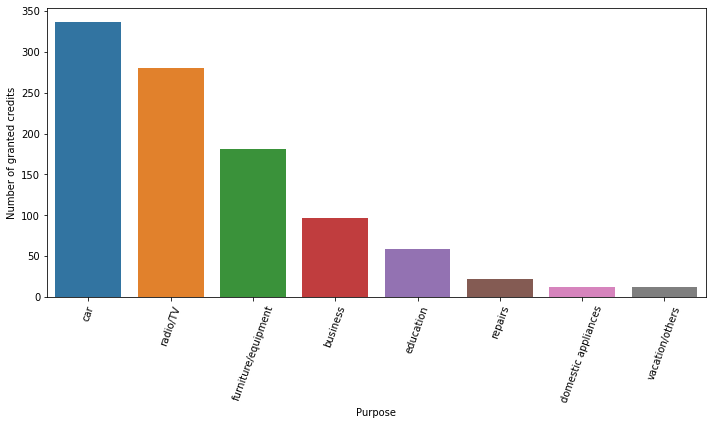

In [21]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()  # Verilen kredilerin hangi amaçla alındığını gösterir.
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=70)
plt.ylabel("Number of granted credits")
plt.tight_layout()

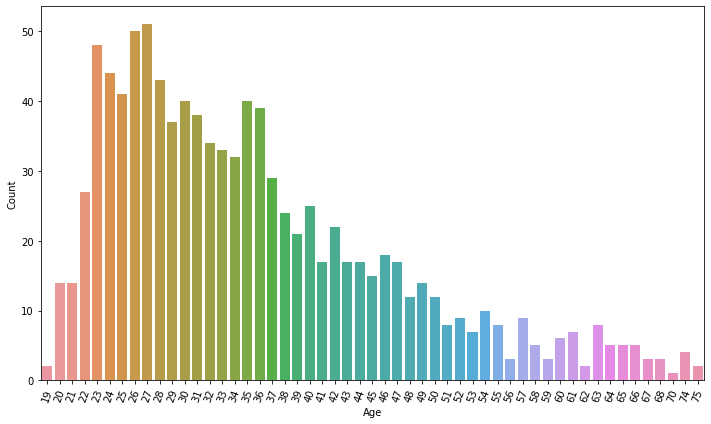

In [22]:
n_credits = data.groupby("Age")["Purpose"].count().rename("Count").reset_index()  # Verilen kredilerin miktarını gösterir.
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Age",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=70)
plt.tight_layout()

In [23]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(15,7))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

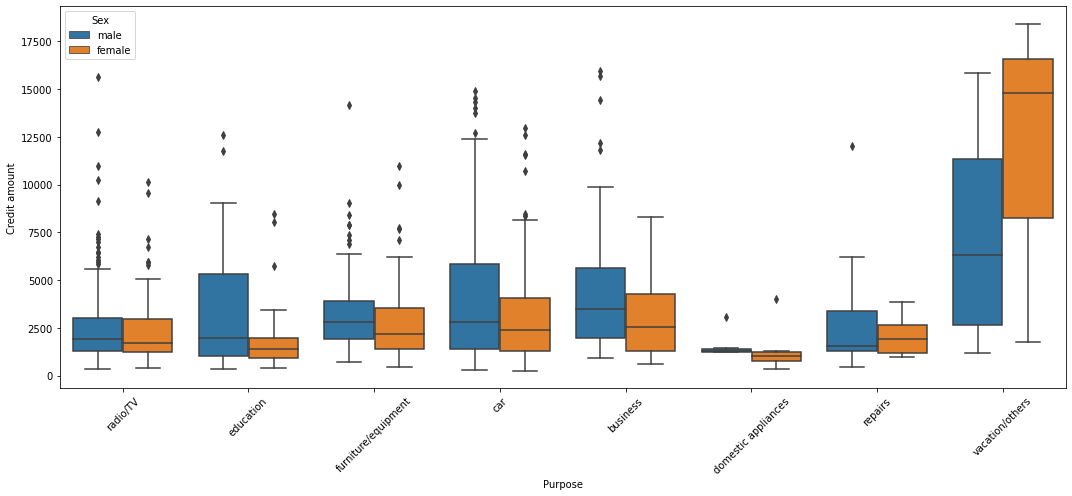

In [24]:
boxes("Purpose","Credit amount","Sex")

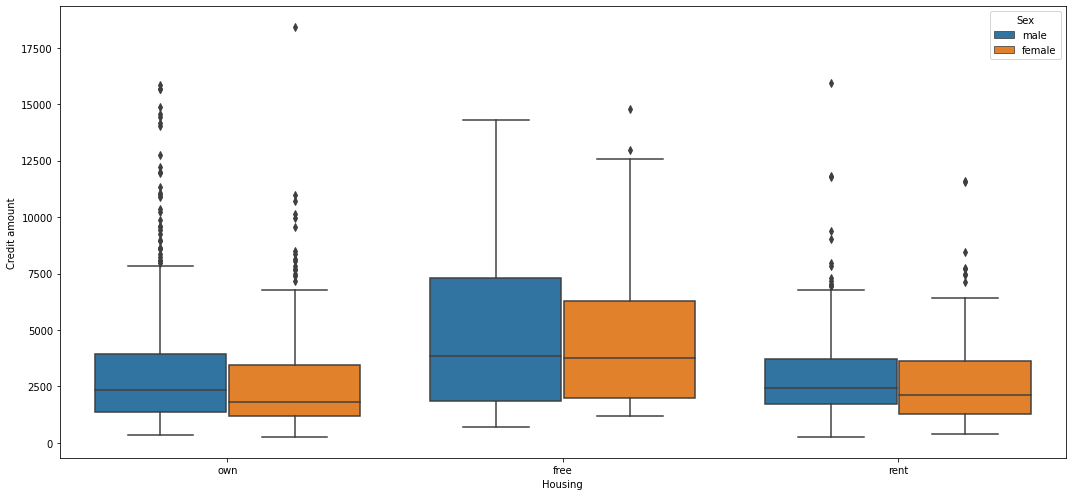

In [25]:
boxes("Housing","Credit amount","Sex",r=0)

In [26]:
data.rename(columns = {'Saving accounts': 'Saving_accounts'}, inplace=True)
data.rename(columns = {'Checking account': 'Checking_account'}, inplace=True)
data.rename(columns = {'Credit amount': 'Credit_amount'}, inplace=True)

In [27]:
data.head(5)

Age     Sex  Job Housing Saving_accounts Checking_account  Credit_amount  \
0   67    male    2     own          little           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little           little           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [28]:
print("Sex' : ",data['Sex'].unique())
print("Housing : ",data['Housing'].unique())
print("Saving_accounts : ",data['Saving_accounts'].unique())
print("Checking_account : ",data['Checking_account'].unique())
print("Purpose : ",data['Purpose'].unique())

Sex' :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving_accounts :  ['little' 'quite rich' 'rich' 'moderate']
Checking_account :  ['little' 'moderate' 'rich']
Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [29]:
# Kategorik Değişkenlerin Dönüştürülmesi

from sklearn import preprocessing   # LabelEncoder için gerekli işlemlerin yapılması
le = preprocessing.LabelEncoder()   # Kategorik sütunları nümerik değerlere dönüştürür
 
data['Sex'] = le.fit_transform(data['Sex'])
data['Housing'] = le.fit_transform(data['Housing'])
data['Saving_accounts'] = le.fit_transform(data['Saving_accounts'])
data['Checking_account'] = le.fit_transform(data['Checking_account'])
data['Purpose'] = le.fit_transform(data['Purpose'])

data.head(5)  # Veri kümemizin nümerik halini görebiliriz.

Age  Sex  Job  Housing  Saving_accounts  Checking_account  Credit_amount  \
0   67    1    2        1                0                 0           1169   
1   22    0    2        1                0                 1           5951   
2   49    1    1        1                0                 0           2096   
3   45    1    2        0                0                 0           7882   
4   53    1    2        0                0                 0           4870   

   Duration  Purpose  Risk  
0         6        5  good  
1        48        5   bad  
2        12        3  good  
3        42        4  good  
4        24        1   bad

In [30]:
# 3- KÜTÜPHANELERİN YÜKLENMESİ VE MODELİN UYGULANMASI 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Modelleri uygulamadan önce veri kümemizi train ve test olarak ayırıyoruz.
# Train: kullanılan veriler, Test: Eğitim için kullanılmayan veriler  # hangi test verisini seçtiğimiz önemli
# Random_state: Her zaman aynı sayıyı üreterek sürekliliği sağlar.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('Sex', axis=1), data['Sex'], test_size = 0.25, random_state=45) # Satır; axis=0   Sütun; axis=1

# Veri kümesinin %25'i test, %75'i ise eğitim olarak ayrıldı.


In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_score = lr.score(X_test,y_test)
print("Test Accuracy of LR Algorithm: {:.2f}%".format(lr_score*100))


In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_score = nb.score(X_test,y_test)
print("Test Accuracy of Naive Bayes: {:.2f}%".format(nb_score*100))

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_score = dtc.score(X_test, y_test)
print("Decision Tree Test Accuracy {:.2f}%".format(dtc_score*100))


In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print("Random Forest Algorithm Accuracy Score: {:.2f}%".format(rf_score*100))

In [ ]:
nn = MLPClassifier()
nn.fit(X_train, y_train)
nn_score = nn.score(X_test, y_test)
print("MLP Classifier Accuracy Score: {:.2f}%".format(nn_score*100))

## Fairness

In [31]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [32]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [33]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [35]:
data.loc[data['Risk'] == 'bad', 'Risk'] = 1
data.loc[data['Risk'] == 'good', 'Risk'] = 0
data

Age  Sex  Job  Housing  Saving_accounts  Checking_account  Credit_amount  \
0     67    1    2        1                0                 0           1169   
1     22    0    2        1                0                 1           5951   
2     49    1    1        1                0                 0           2096   
3     45    1    2        0                0                 0           7882   
4     53    1    2        0                0                 0           4870   
..   ...  ...  ...      ...              ...               ...            ...   
995   31    0    1        1                0                 0           1736   
996   40    1    3        1                0                 0           3857   
997   38    1    2        1                0                 0            804   
998   23    1    2        0                0                 0           1845   
999   27    1    2        1                1                 1           4576   

     Duration  Purpose Risk  
0           6        5    0  
1          48        5    1  
2          12        3    0  
3          42        4    0  
4          24        1    1  
..        ...      ...  ...  
995        12        4    0  
996        30        1    0  
997        12        5    0  
998        45        5    1  
999        45        1    0  

[1000 rows x 10 columns]

In [36]:
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]
dataset_orig = StandardDataset(data,
                                  label_name='Risk',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[0],
                                  privileged_classes=[[1]])


In [37]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.074801


In [38]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

num_estimators = 1000

model = RandomForestClassifier(n_estimators = 1000, random_state = 1)

mdl = model.fit(X_train, y_train)
with open('../../Results/RF/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/RF/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/RF/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [39]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = RandomForestClassifier(n_estimators=i, random_state = 1)

    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [40]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/RF/' + nb_fname + '.csv')
final_result

classifier        T0        T1        T2  \
accuracy                         0.720000  0.583333  0.530000  0.636667   
f1                               0.820513  0.692875  0.609418  0.750572   
statistical_parity_difference   -0.114506 -0.094223 -0.054685 -0.117330   
equal_opportunity_difference    -0.039644 -0.050252 -0.031073 -0.085932   
average_abs_odds_difference      0.129551  0.111664  0.055129  0.123848   
disparate_impact                -0.138905 -0.150787 -0.114058 -0.162906   
theil_index                      0.127632  0.330948  0.472885  0.235138   

                                     T3        T4        T5        T6  \
accuracy                       0.640000  0.666667  0.663333  0.670000   
f1                             0.736585  0.777778  0.763466  0.783370   
statistical_parity_difference -0.108858 -0.072914 -0.114763 -0.060847   
equal_opportunity_difference  -0.115611 -0.043180 -0.079396 -0.023465   
average_abs_odds_difference    0.077036  0.073061  0.107006  0.067728   
disparate_impact              -0.172294 -0.094359 -0.166960 -0.076206   
theil_index                    0.283093  0.191852  0.235161  0.177399   

                                     T7        T8  ...      T990      T991  \
accuracy                       0.683333  0.703333  ...  0.723333  0.720000   
f1                             0.783599  0.806100  ...  0.823028  0.820513   
statistical_parity_difference -0.065469 -0.116816  ... -0.103979 -0.114506   
equal_opportunity_difference  -0.023572 -0.085610  ... -0.023251 -0.039644   
average_abs_odds_difference    0.059297  0.108982  ...  0.121354  0.129551   
disparate_impact              -0.088769 -0.147158  ... -0.125299 -0.138905   
theil_index                    0.200239  0.152956  ...  0.123954  0.127632   

                                   T992      T993      T994      T995  \
accuracy                       0.720000  0.720000  0.723333  0.720000   
f1                             0.820513  0.820513  0.823028  0.820513   
statistical_parity_difference -0.114506 -0.114506 -0.119384 -0.114506   
equal_opportunity_difference  -0.039644 -0.039644 -0.046180 -0.039644   
average_abs_odds_difference    0.129551  0.129551  0.132819  0.129551   
disparate_impact              -0.138905 -0.138905 -0.144414 -0.138905   
theil_index                    0.127632  0.127632  0.123954  0.127632   

                                   T996      T997      T998      T999  
accuracy                       0.720000  0.720000  0.723333  0.720000  
f1                             0.820513  0.820513  0.823028  0.820513  
statistical_parity_difference -0.114506 -0.114506 -0.119384 -0.114506  
equal_opportunity_difference  -0.039644 -0.039644 -0.046180 -0.039644  
average_abs_odds_difference    0.129551  0.129551  0.132819  0.129551  
disparate_impact              -0.138905 -0.138905 -0.144414 -0.138905  
theil_index                    0.127632  0.127632  0.123954  0.127632  

[7 rows x 1001 columns]